How good are the pushers in Dota 2 pro games

What is Dota 2?

Dota (Defense of the Ancients) 2 is a free multiplayer online battle arena game developed by Valve. It originally was a custom game map in Warcraft III. Dota 2 games are played between two teams. Each of the two teams has five players, representing Radiant and Dire, and compete on the game map. Each player controls one of 117 "heroes", each with their own unique abilities and operating system. At the beginning of each game, all 10 heroes are at level 1, and they gain experience by fighting to level up and become stronger. With each level of a hero, players can learn a new ability, enhance an existing ability, or choose a talent. How each hero fights is determined by their starting stats - Strength, Agility, and Intelligence. The goal of the game for each team is to destroy the base in the opposing fortress.

A river divides the map into two parts, with Radiant and Dire's bases on opposite corners of the map, with Radiant at the bottom left and Dire at the top right. In addition, a fountain is used to revive heroes or to quickly restore hp and mp to heroes so that they can quickly return to battle. The game ends when one side destroys the other side's base. Three roads connect the two fortresses. Each road has two defense towers that automatically attack. Computer-controlled minions will follow the road to the fortress on the other side. thing. Because of computer mechanical control, all minions will be attacked to death without exception. Radiant and Dire maps are populated with neutrals, the strongest neutral being Roshan. Whichever side kills Roshan will get a reward.


What is a pusher?

According to the explanation of Dota 2 wiki, pushers are the hero who "can quickly siege and destroy towers and barracks at all points of the game." Usually one side will not choose to start a battle under the other's tower, this is because the tower can provide better vision, faster support speed, and strong damage. Destroying towers is often the reward for the winning side of a teamfight. However, since pushers can deal a lot of damage to defense towers in a short period of time, the side with one or more pushers often use roundabout strategy, that is, destroying the opponent's defense towers without participating in team battles. This makes games with pushers often very different from regular games. Especially, pushers have helped many teams win world championships. So, my question is, do pushers perform better in pro games than other heroes?

Data collection

 I will use opendota api (https://www.opendota.com/) to collect data. It provides Dota 2 related data including advanced match data extracted from match replays. Most of result it returns will be in json format, and I will use those result to create my data frame. Opendota API are based on the most recent real games, so the data will change every time it's called. Also, ｂecause it has access restrictions, you can't get all the data at once. For convenience, in the code below, I downloaded the data locally, and my subsequent analysis will be based on this local data.

Code explanation:
1. Call https://api.opendota.com/api/heroes, it will return all current heroes in Dota 2.
2. Foreach hero, call https://api.opendota.com/api/benchmarks?hero_id=[hero_id] to get the hero's performance in recent pro games
3. Save the data locally
4. Select and compute the data that we need.
5. Add data to different data frame based on the hero's role.

https://api.opendota.com/api/heroes response: 
[
    {
        "id": 0,
        "name": "string",
        "localized_name": "string",
        "primary_attr": "string",
        "attack_type": "string",
        "roles": []
    }
]

 https://api.opendota.com/api/benchmarks response: 
 {
    "hero_id": 0,
    "result": 
    {
        "gold_per_min": [],
        "xp_per_min": [],
        "kills_per_min": [],
        "last_hits_per_min": [],
        "hero_damage_per_min": [],
        "hero_healing_per_min": [],
        "tower_damage": []
    }
}


In [139]:

import requests
import json
import pandas as pd
from os.path import isfile
import os
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [140]:
# download data from opendota api
filename_id = {}

heroes_req = requests.get("https://api.opendota.com/api/heroes")
heroes = json.loads(heroes_req.text)
for hero in heroes:
    if 'Pusher' in hero['roles']:
        filename = "pushers/" + hero["name"] + ".json"
    else:
        filename = "others/" + hero["name"] + ".json"
    filename_id[filename] = hero["id"]
    if isfile(filename):
        with open(filename, 'r') as f: 
            c = f.readline()
        if c != "{\"error\":\"rate limit exceeded\"}":
            continue

    hero_req = requests.get("https://api.opendota.com/api/benchmarks?hero_id=" + str(hero["id"]))
    with open(filename, 'w') as f: 
        f.write(hero_req.text)



In [141]:
# read local data
pushers = []
others = []
def read_files(folder, arr):
    for filename in os.listdir(folder):
        if filename == 'npc_dota_hero_marci.json':
            continue
        f = folder + "/" + filename
        if os.path.isfile(f):
            with open(f, 'r') as file:
                s = file.read()
                js = json.loads(s)
                id = filename_id[f]
                name = filename[14: filename.index('.')]
                gpm = js['result']['gold_per_min'][4]['value']
                xpm = js['result']['xp_per_min'][4]['value']
                kpm = js['result']['kills_per_min'][4]['value']
                lhpm = js['result']['last_hits_per_min'][4]['value']
                td = js['result']['tower_damage'][4]['value']
                t = td / gpm
                kpg = kpm / gpm
                arr.append(pd.DataFrame({'id': id,'name': name, 'gold per min': gpm, 'xp per min': xpm, 'kill per min': kpm, 'last hit per min': lhpm, 'kill per gold': kpg, 'tower damage': td, 'tower damage / gpm': t}, index=[name]))

read_files('pushers', pushers)
read_files('others', others)
pushers_df = pd.concat(pushers)
others_df = pd.concat(others)
print(others_df)
        

                     id                name  gold per min  xp per min  \
abaddon             102             abaddon           316         519   
abyssal_underlord   108   abyssal_underlord           453         619   
alchemist            73           alchemist           687         708   
ancient_apparition   68  ancient_apparition           321         493   
antimage              1            antimage           602         767   
...                 ...                 ...           ...         ...   
windrunner           21          windrunner           413         602   
winter_wyvern       112       winter_wyvern           338         514   
wisp                 91                wisp           263         474   
witch_doctor         30        witch_doctor           327         487   
zuus                 22                zuus           455         633   

                    kill per min  last hit per min  kill per gold  \
abaddon                 0.070148          1.631206    

Now we have heroes' gold per min, xp per min, kill per min, last hit per min, kill per gold, and tower damage. We also need to know heroes' win rate. Unfortunately, https://api.opendota.com/api/benchmarks doesn't return it. We need to call https://api.opendota.com/api/heroStats and compute it. Here, we may have 2 null values. They are Marci and Primal Beast. The reason is that they are newly released heroes, and database doesn't have their data yet. I will skip those heroes.

https://api.opendota.com/api/heroStats response:
[
    {
        ...,
        "id": 0,
        "name": "string",
        "pro_win": 0,
        "pro_pick": 0,
    }
]

In [142]:
# calculate win rate
heroStats = requests.get("https://api.opendota.com/api/heroStats")
js = json.loads(heroStats.text)
pushers_df['win rate'] = pd.NaT
others_df['win rate'] = pd.NaT
for j in js:
    if len(pushers_df.loc[pushers_df['id'] == j['id']]) != 0:
        r = pushers_df.loc[pushers_df['id'] == j['id']]
        if 'pro_pick' in j and j['pro_pick'] != 0:
            pro_pick = j['pro_pick']
            pro_win = j['pro_win']
            winrate = pro_win / pro_pick
            pushers_df.loc[pushers_df['id'] == j['id'], 'win rate'] = winrate
    else:
        r = others_df.loc[others_df['id'] == j['id']]
        if 'pro_pick' in j and j['pro_pick'] != 0:
            pro_pick = j['pro_pick']
            pro_win = j['pro_win']
            winrate = pro_win / pro_pick
            others_df.loc[others_df['id'] == j['id'], 'win rate'] = winrate

pushers_df = pushers_df.dropna()
others_df = others_df.dropna()


We have 2 data frames 'pushers_df' and 'others_df'. 'pushers_df' contains the data of the heroes that are officially labeled as 'pusher'.
Based on the official explanation, pushers are the heroes who can deal a lot of damage on tower. The first thing I need to know it that can the heroes in 'pushers_df' really deal more damage tham the heroes in 'others_df'?

Hypothesis test:
H0: The mean tower damage / gpm of all heroes are equal
H1: The mean tower damage / gpm of pushers and other heroes are not equal

In [143]:
pushers_td = pushers_df['tower damage / gpm'].to_list()
others_td = others_df['tower damage / gpm'].to_list()
_, t = ttest_ind(others_td, pushers_td)

print(t)

1.7970123515505763e-14


As we can see, t is extremely small, and it means we can reject H0 and conduct a conclusion that the mean tower damage / gpm pushers and other heroes can deal are not similar at all.
The next question is, can pushers deal more tower damage?

Below is that code that will make a gpm vs tower damage scatter plot.

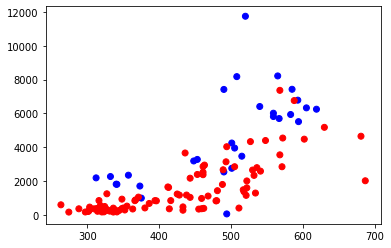

In [144]:
x = []
y = []
c = []

for i, r in pushers_df.iterrows():
    x.append(r['gold per min'])
    y.append(r['tower damage'])
    c.append('b')

for i, r in others_df.iterrows():
    x.append(r['gold per min'])
    y.append(r['tower damage'])
    c.append('r')

plt.scatter(x, y, c=c)
plt.show()


The blue dots are pushers and red dots are other heroes. As we can see, in the similar gpm, pushers can always deal more tower damage.

Now we have 6 values for each hero except tower damage:
Win rate: The hero's overall win rate in pro games
Gold per min: Heroes gain gold by farming (mainly) or killing enemy heroes. Gpm can show how good the hero can get resources.
Xp per min: Similar to gpm, but the standard deviation will be smaller.
Kill per min: Focus on how the hero is good at kill enemy heroes.
Last hit per min: Focus on the speed the hero can farm
Kill per gold: Even two heroes have similar items, their strength may be different. This value shows the ability that the hero can maximize the ability of items.

Next, I will make boxplots to compare how pushers perform differently from the other heroes.

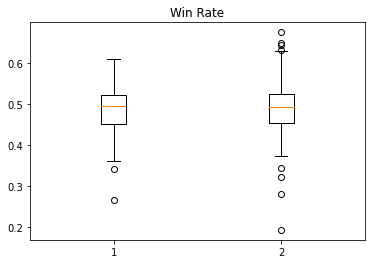

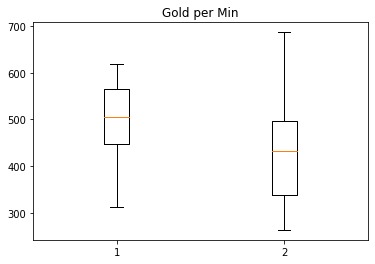

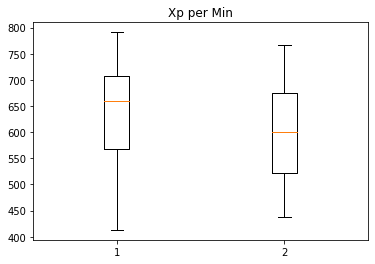

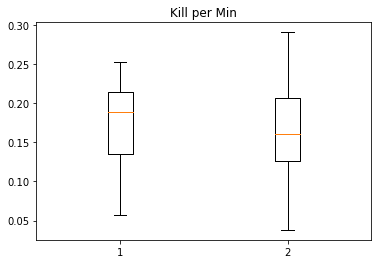

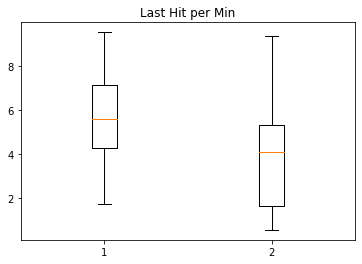

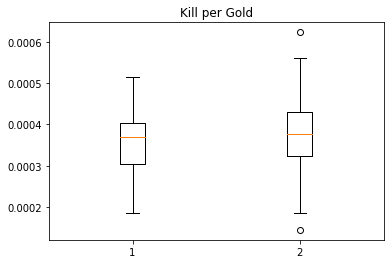

In [145]:
plt.boxplot([pushers_df['win rate'].to_list(), others_df['win rate'].to_list()])
plt.title("Win Rate")
plt.show()
plt.boxplot([pushers_df['gold per min'].to_list(), others_df['gold per min'].to_list()])
plt.title("Gold per Min")
plt.show()
plt.boxplot([pushers_df['xp per min'].to_list(), others_df['xp per min'].to_list()])
plt.title("Xp per Min")
plt.show()
plt.boxplot([pushers_df['kill per min'].to_list(), others_df['kill per min'].to_list()])
plt.title("Kill per Min")
plt.show()
plt.boxplot([pushers_df['last hit per min'].to_list(), others_df['last hit per min'].to_list()])
plt.title("Last Hit per Min")
plt.show()
plt.boxplot([pushers_df['kill per gold'].to_list(), others_df['kill per gold'].to_list()])
plt.title("Kill per Gold")
plt.show()

From the plots, the win rates seem similar, but let's do one more hypothesis test to confirm that.

H0: the mean win rate of all heroes are equal
H1: the mean win rate of pushers and other heroes are not equal

In [146]:
pushers_wr = pushers_df['win rate'].to_list()
others_wr = others_df['win rate'].to_list()
_, t = ttest_ind(pushers_wr, others_wr)

print(t)

0.5608958937166812


The t is 0.57 so we are failed to reject H0, and we don't have enough evidence to say that the mean win rate of pushers and other heroes have significant difference.
Pushers win in gpm, xpm, kpm, and lhpm. Which means pushers in pro games overrall farm faster, kill more enemy heroes, and make more gold and xp, but those advantages don't help them win more. The main reason of it should be that their ability on killing heroes are that not that good when all heroes have similar amount of golds. 

This is actually how they perform in the most of pro games: they have strong abilities to clear enemy waves and damage towers, which give them more last hits, gold and xp, and they usually have higher levels and better items. However, once their team fail to win the game on the advantage of towers and golds, after the enemy heroes get similar items, those heroes will lose teamfights and finally lose the whole late game.

The next question is, do pro players love to pick pushers? and which pusher is the most favorite?

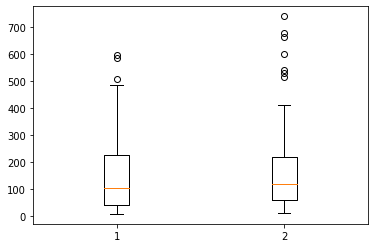

0.7025495335260614
184.6206896551724
171.04347826086956


In [147]:
heroStats = requests.get("https://api.opendota.com/api/heroStats")
js = json.loads(heroStats.text)
pushers_df['pick'] = 0
others_df['pick'] = 0
for j in js:
    if len(pushers_df.loc[pushers_df['id'] == j['id']]) != 0:
        r = pushers_df.loc[pushers_df['id'] == j['id']]
        if 'pro_pick' in j:
            pushers_df.loc[pushers_df['id'] == j['id'], 'pick'] = j['pro_pick']
    else:
        r = others_df.loc[others_df['id'] == j['id']]
        if 'pro_pick' in j:
            others_df.loc[others_df['id'] == j['id'], 'pick'] = j['pro_pick']

pushers_df = pushers_df.dropna()
others_df = others_df.dropna()

plt.boxplot([pushers_df['pick'].to_list(), others_df['pick'].to_list()])
plt.show()

pushers_wr = pushers_df['pick'].to_list()
others_wr = others_df['pick'].to_list()
_, t = ttest_ind(pushers_wr, others_wr)

print(t)

mean_pushers_pick = pushers_df['pick'].mean()
mean_others_pick = others_df['pick'].mean()
print(mean_pushers_pick)
print(mean_others_pick)

As we can see, the mean amount of picks of pushers are a little higher, but overrall, it's not that different from the picks of other heroes. There are lots of outlier in both pushers and other heroes. That's because some hero are very popular in the current version. 

In [148]:
dft = pushers_df.sort_values(by=['pick'], ascending=False)
print(dft.head())

dft = pushers_df.sort_values(by=['win rate'], ascending=False)
print(dft.head())

               id           name  gold per min  xp per min  kill per min  \
dragon_knight  49  dragon_knight           453         617      0.140460   
tiny           19           tiny           559         713      0.207164   
death_prophet  43  death_prophet           448         638      0.200418   
pugna          45          pugna           357         513      0.127011   
chaos_knight   81   chaos_knight           515         667      0.241935   

               last hit per min  kill per gold  tower damage  \
dragon_knight          4.723468       0.000310          3285   
tiny                   7.058824       0.000371          5817   
death_prophet          4.259819       0.000447          3195   
pugna                  2.116183       0.000356          2355   
chaos_knight           5.477756       0.000470          3476   

               tower damage / gpm  win rate  pick  
dragon_knight            7.251656  0.518395   598  
tiny                    10.406082  0.495726   585  
de

In the current version, the most picked pusher is dragon knight, and visage has the highest win rate.

Conclusion

Overall, pushers are popular in pro games. Their pick rates are higher than other heroes. The win rates are similar to other heroes, and their abilities of killing enermy heroes are weak. However, Their abilities can quickly destroy towers and establish a vision advantage, while their ability to quickly level up their gears gives them great control in the early and mid-game.